# Machine Learning: Feature Importance, Decision Tree, Random Forest, Ridge, Lasso, Elastic Net Regression on Housing Prices

In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import matplotlib.pyplot as plt 
import sklearn.model_selection as ms
pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 85)
import random

## Data Preparation

In [148]:
# Loading up Data Frames from CSV files
house_features = pd.read_csv('EDA_Final.csv')
nominal = pd.read_csv('Nominal.csv')
ordinal = pd.read_csv('Ordinal.csv')
numeric = pd.read_csv('Numeric.csv').drop(columns='SalePrice')
Y = np.log(pd.read_csv('SalePrice_final.csv')) # Takes away skewing
Y = Y.SalePrice # removes index and prepped to be used as response variable.

In [32]:
# This is used to make the grid_tree_search easier. Thanks Aiko.

def get_error(X_train, Y_train, X_test, Y_test, model, show = True):
    model.fit(X_train, Y_train)
    train_error = 1 - model.score(X_train, Y_train)
    test_error  = 1 - model.score(X_test, Y_test)
    if show:
        print("The training error is: %.5f" %train_error)
        print("The test     error is: %.5f" %test_error)
    return [train_error, test_error]

### Correlation Check and Feature Removal

In [34]:
# Checking for Correlation
def correlation_generator(correlation):
    d =dict()
    for i in range(correlation.shape[0]//2):
        for j in range(correlation.shape[1]):
            if i!=j and correlation.iloc[i,j]>0.7:
                t1 = correlation.index[i]
                t2 = correlation.columns[j]
                if t1 != t2:
                    t = t1 +','+t2
                    d[t] = correlation.iloc[i,j]    
    return(d)

numeric_corr = numeric.corr()
ordinal_corr = ordinal.corr()

print('Numeric:', correlation_generator(numeric_corr), sep='\n')
print('Ordinal:', correlation_generator(ordinal_corr), sep='\n')

Numeric:
{'TotalBsmtSF,X1stFlrSF': 0.8195299750050355, 'X1stFlrSF,TotalBsmtSF': 0.8195299750050355, 'GrLivArea,TotRmsAbvGrd': 0.8254893743088377}
Ordinal:
{'ExterQual,KitchenQual': 0.7161221955032785}


In [35]:
# Remove highly correlated values:
uncorrelated_numeric = numeric.drop(columns=['TotalBsmtSF', 'GrLivArea'])
uncorrelated_ordinal = ordinal.drop(columns='KitchenQual')

In [36]:
# Concatenate the dataframes together
nominal_dummified = pd.get_dummies(nominal, drop_first=True)
X = pd.concat([nominal_dummified, uncorrelated_ordinal, uncorrelated_numeric], axis=1)

## Modeling

### Tree Model

In [37]:
# Tree Modeling
random.seed(10)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, Y_train)

print("Training error: " + str(1-tree_model.score(X_train, Y_train)))
print("Test error: " + str(1-tree_model.score(X_test, Y_test)))
print("R^2 Training: " + str(tree_model.score(X_train, Y_train)))
print("R^2 Test: " + str(tree_model.score(X_test, Y_test)))

Training error: 0.0
Test error: 0.3388559917227447
R^2 Training: 1.0
R^2 Test: 0.6611440082772553


Text(0.5, 0, 'Importance of Feature')

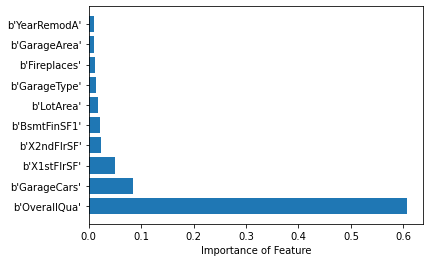

In [149]:
# Calculates the important features.
feature_importance = list(zip(X.columns, tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]

# This plots the top 10 features based on importance
featureNames, featureScores = zip(*list(feature_sort))
plt.barh(range(0,10), featureScores[0:10], tick_label=featureNames[0:10])
plt.xlabel('Importance of Feature')

In [39]:
# This changes the depth of the tree to see which is the best. This is just calculations.
grid_para_tree = [
    {'max_depth': range(1, 31)}
]

tree_model.set_params(random_state=0)
grid_search_tree = ms.GridSearchCV(tree_model, grid_para_tree, cv=5, n_jobs=-1, return_train_score=True)
grid_search_tree.fit(X_train, Y_train)


# This lets us know the best score.
print('Least Amount of Error:', 1 - grid_search_tree.best_score_)
print('Best Depth:',grid_search_tree.best_index_)

Least Amount of Error: 0.28293976047682423
Best Depth: 5


Text(0.5, 0, 'depth')

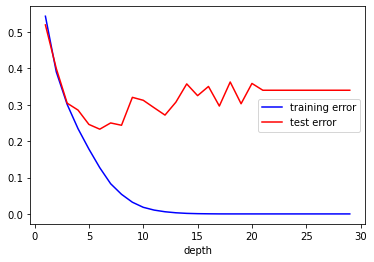

In [40]:
# This plots where we decide to choose (5)

depth  = range(1, 30)
tree_train = []
tree_test = []
for i in depth:
    tree_model.set_params(max_depth = i)
    error = get_error(X_train, Y_train, X_test, Y_test, tree_model, show=False)
    tree_train.append(error[0])
    tree_test.append(error[1])


plt.plot(depth, tree_train, c = 'blue', label='training error')
plt.plot(depth, tree_test, c = 'red', label='test error')
plt.legend(loc=7)
plt.xlabel('depth')

### Forest Model

In [41]:
# Forest Modeling

randomForest = ensemble.RandomForestRegressor()
randomForest.fit(X_train, Y_train) 

print("The training error is: %.5f" % (1 - randomForest.score(X_train, Y_train)))
print("The test error is: %.5f" % (1 - randomForest.score(X_test, Y_test)))

# Random forest does much better.

The training error is: 0.01989
The test error is: 0.14117


Text(0.5, 0, 'Importance of Feature')

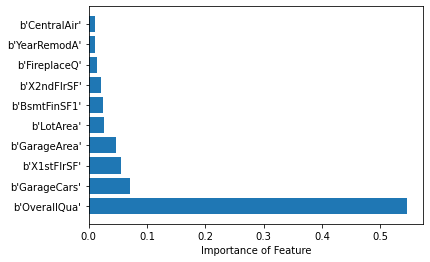

In [150]:
# Calculates the important features for Forests
feature_importance = list(zip(X.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]

# This plots the top 10 features based on importance
featureNames, featureScores = zip(*list(feature_sort))
plt.barh(range(0,10), featureScores[0:10], tick_label=featureNames[0:10])
plt.xlabel('Importance of Feature')

# We see that there are few differences in which features are the most important

### Ridge, Lasso and Elastic Net Model

In [43]:
# Linear Regression with Ridge, Lasso and Elastic net
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()

In [96]:
# Ridge
ridge.set_params(alpha=1.0, normalize=True)
ridge.fit(X_train, Y_train)
print('Training Score:', ridge.score(X_train, Y_train), sep='\n')
print('Test Score:', ridge.score(X_test, Y_test), sep='\n')

Training Score:
0.9057794565366141
Test Score:
0.8003683489531108


In [103]:
# Choosing from a range of alphas to see what is a good value
coefs = []
intercepts = []
R2_train  = []
R2_test = []
alphaRange = np.linspace(1,30,200)
for alpha in alphaRange:
    ridge.set_params(alpha=alpha)  
    ridge.fit(X_train, Y_train)
    intercepts.append(ridge.intercept_)
    coefs.append(ridge.coef_)
    R2_train.append(ridge.score(X_train, Y_train))
    R2_test.append(ridge.score(X_test, Y_test))

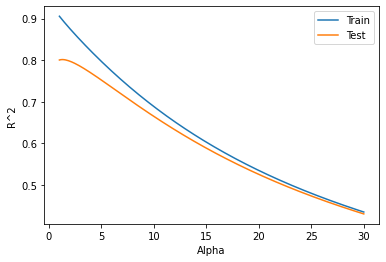

In [104]:
# Using the plot to estimate a good alpha
plt.plot(alphaRange, R2_train)
plt.plot(alphaRange, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()
# Looks like our model overfits and always stays above test. A small alpha of about 1.4 gives us the best result.

In [145]:
# Lasso
lasso.set_params(alpha=1, normalize=True)
lasso.fit(X_train, Y_train)
print('Training Score:', lasso.score(X_train, Y_train), sep='\n')
print('Testing Score:', lasso.score(X_test, Y_test), sep='\n')
# Clearly, alpha was too large.

Training Score:
0.0
Testing Score:
-7.992313858662392e-05


In [116]:
# Choosing from a range of alphas to see what is a good value
coefs = []
intercepts = []
R2_train  = []
R2_test = []
alphaRange = np.linspace(1e-3,0.01,200)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha)  
    lasso.fit(X_train, Y_train)
    intercepts.append(lasso.intercept_)
    coefs.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, Y_train))
    R2_test.append(lasso.score(X_test, Y_test))

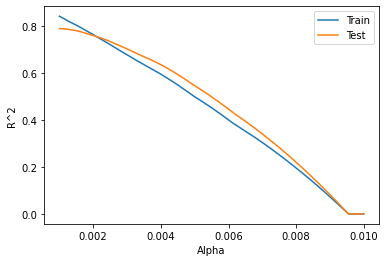

In [117]:
# Using the plot to find a good alpha.
plt.plot(alphaRange, R2_train)
plt.plot(alphaRange, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()
# We see that it crosses at about 0.001. So it is a good alpha to choose from.

In [136]:
# Lasso Redone
lasso.set_params(alpha=0.001, normalize=True)
lasso.fit(X_train, Y_train)
print('Training Score:', lasso.score(X_train, Y_train), sep='\n')
print('Testing Score:', lasso.score(X_test, Y_test), sep='\n')

Training Score:
0.8430054396174362
Testing Score:
0.7905442097409962


In [144]:
# Elastic Net
net.set_params(alpha=1, normalize=True)
net.fit(X_train, Y_train)
print('Training Score:', net.score(X_train, Y_train), sep='\n')
print('Testing Score:', net.score(X_test, Y_test), sep='\n')
# Needs a smaller alpha.

Training Score:
0.0
Testing Score:
-7.992313858662392e-05


In [140]:
# Test out some alphas.
coefs = []
intercepts = []
R2_train  = []
R2_test = []
alphaRange = np.linspace(1e-3,0.01,200)
for alpha in alphaRange:
    net.set_params(alpha=alpha)  
    net.fit(X_train, Y_train)
    intercepts.append(net.intercept_)
    coefs.append(net.coef_)
    R2_train.append(net.score(X_train, Y_train))
    R2_test.append(net.score(X_test, Y_test))

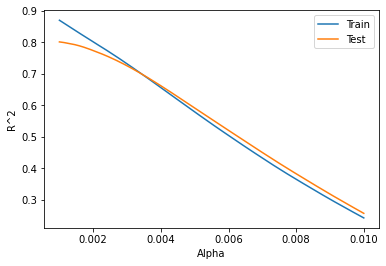

In [141]:
# Plotting alphas compared to R^2
plt.plot(alphaRange, R2_train)
plt.plot(alphaRange, R2_test)
plt.legend(('Train', 'Test'))
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()
# Looks like 0.003 is a good value

In [143]:
# Elastic Net Redone.
net.set_params(alpha=0.003, normalize=True)
net.fit(X_train, Y_train)
print('Training Score:', net.score(X_train, Y_train), sep='\n')
print('Testing Score:', net.score(X_test, Y_test), sep='\n')

Training Score:
0.7315576274212015
Testing Score:
0.7252742307843194


## Conclusion
The best result from this was the random forest and is perhaps the most reliable. It seems that overall quality of the house is what matters the most for the sales price as well as number of cars that can fit in the garage.